<a href="https://colab.research.google.com/github/dhruvi-m/dhruvi-mehta/blob/main/bd__assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dhruvi Mehta
## 202318003

**(1)setup and Data Preparation**



● Install and configure PySpark in your environment.


● Initialize a Spark session and load the Online News Popularity dataset into a PySpark DataFrame.



● Familiarize yourself with the dataset's structure and types of variables available.

In [44]:
pip install pyspark

In [17]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Online News Popularity Prediction") \
    .getOrCreate()


In [4]:
# Load dataset into a DataFrame
dataset_path = "/content/OnlineNewsPopularity.csv"
news_df = spark.read.csv(dataset_path, header=True, inferSchema=True)


In [5]:
# Print the schema of the DataFrame
news_df.printSchema()

# Display the first few rows of the DataFrame
news_df.show(5)


root
 |-- url: string (nullable = true)
 |--  timedelta: double (nullable = true)
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: do

**2. Data Preprocessing**


● Perform data cleaning, including dealing with missing values and any irrelevant features.


● Since the dataset contains URL data as non-predictive, ensure this is excluded from your analysis.


● Convert the dataset's target variable (shares) into a binary outcome for classification (popular vs. not
popular) based on a threshold you define (e.g., median value).

In [6]:
from pyspark.sql.functions import col

# Step 1: Handling Missing Values

news_df = news_df.dropna()

In [7]:
##Step 2: Excluding Irrelevant Features

columns_to_exclude = ['url', 'timedelta']  # Assuming 'url' and 'timedelta' are irrelevant
news_df = news_df.drop(*columns_to_exclude)

In [ ]:
print(news_df)

DataFrame[ timedelta: double,  n_tokens_title: double,  n_tokens_content: double,  n_unique_tokens: double,  n_non_stop_words: double,  n_non_stop_unique_tokens: double,  num_hrefs: double,  num_self_hrefs: double,  num_imgs: double,  num_videos: double,  average_token_length: double,  num_keywords: double,  data_channel_is_lifestyle: double,  data_channel_is_entertainment: double,  data_channel_is_bus: double,  data_channel_is_socmed: double,  data_channel_is_tech: double,  data_channel_is_world: double,  kw_min_min: double,  kw_max_min: double,  kw_avg_min: double,  kw_min_max: double,  kw_max_max: double,  kw_avg_max: double,  kw_min_avg: double,  kw_max_avg: double,  kw_avg_avg: double,  self_reference_min_shares: double,  self_reference_max_shares: double,  self_reference_avg_sharess: double,  weekday_is_monday: double,  weekday_is_tuesday: double,  weekday_is_wednesday: double,  weekday_is_thursday: double,  weekday_is_friday: double,  weekday_is_saturday: double,  weekday_is_sun

**3. Exploratory Data Analysis (EDA)**

● Conduct EDA to understand the characteristics of popular and non-popular articles.


● Analyze the distribution of key features and their impact on news popularity.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Step 1: Split Data by Popularity
popular_articles = news_df.filter(news_df["popular"] == 1)
non_popular_articles = news_df.filter(news_df["popular"] == 0)

In [ ]:
# Step 2: Summary Statistics
popular_summary = popular_articles.describe()
non_popular_summary = non_popular_articles.describe()


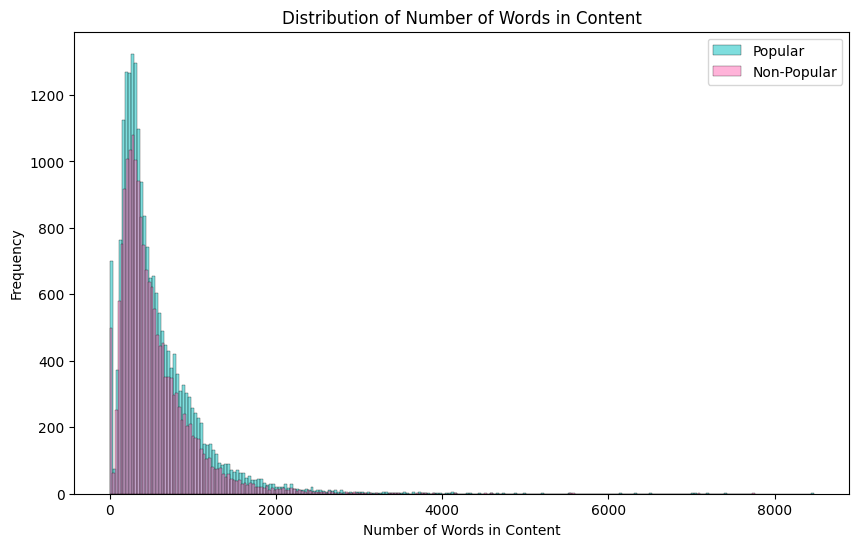

In [ ]:
popular_content_words = popular_articles.select(" n_tokens_content").rdd.flatMap(lambda x: x).collect()
non_popular_content_words = non_popular_articles.select(" n_tokens_content").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
sns.histplot(popular_content_words, color="c", alpha=0.5, label="Popular")
sns.histplot(non_popular_content_words, color="hotpink", alpha=0.5, label="Non-Popular")
plt.xlabel("Number of Words in Content")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Words in Content")
plt.legend()
plt.show()

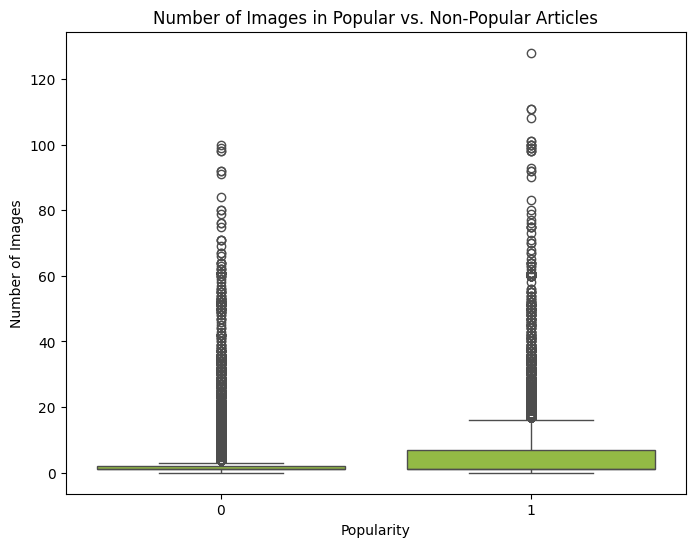

In [ ]:
#Step 4: Feature Analysis

plt.figure(figsize=(8, 6))
sns.boxplot(x="popular", y=" num_imgs", data=news_df.toPandas(),color='yellowgreen')
plt.xlabel("Popularity")
plt.ylabel("Number of Images")
plt.title("Number of Images in Popular vs. Non-Popular Articles")
plt.show()

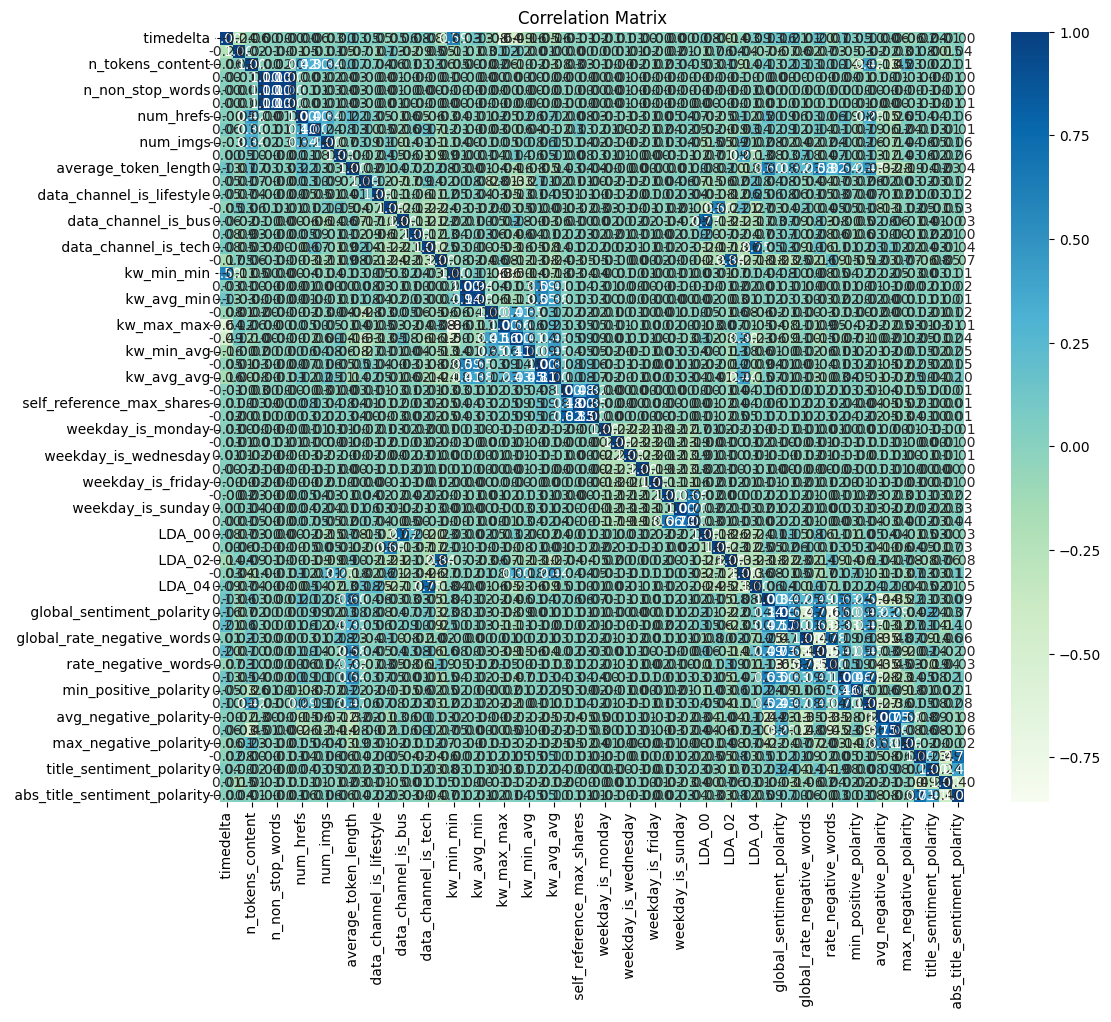

In [ ]:
# Step 5: Correlation Analysis
# Example: Correlation matrix
correlation_matrix = news_df.select([col for col in news_df.columns if col != "popular"]).toPandas().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="GnBu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


**4. Feature Engineering**


● Create new features that could potentially enhance model performance, such as article length
categories, weekday of publication, etc.


● Use VectorAssembler to combine all feature columns into a single vector column.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import dayofweek

In [28]:
spark = SparkSession.builder.appName("NewsPopularityPrediction").getOrCreate()

# Load dataset into a pySpark dataframe
data = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/OnlineNewsPopularity.csv")

# Display dataset
data.printSchema()

root
 |-- url: string (nullable = true)
 |--  timedelta: double (nullable = true)
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: do

In [29]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import col

data = data.withColumnRenamed(" n_tokens_content", "n_tokens_content")
data = data.withColumn("n_tokens_content", col("n_tokens_content").cast("double"))
bucketizer = Bucketizer(splits=[0, 500, 1000, float('inf')], inputCol="n_tokens_content", outputCol="article_length_cat")

# Apply bucketizer to the data
data = bucketizer.transform(data)

**(5)Model Building**


● Split the dataset into training and testing sets (80:20 ratio).


● Train a classification model (e.g., Logistic Regression, Decision Tree, or Random Forest) to predict
article popularity.


● Optionally, explore other algorithms and compare their performances.

In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [30]:

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Show the number of rows in each set
print("Training set count:", train_data.count())
print("Testing set count:", test_data.count())

Training set count: 31819
Testing set count: 7825


In [43]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Assuming 'data' is your DataFrame containing the features and labels
# Define the columns to exclude from features
excluded_cols = ["shares", "popularity"]

# Filter out non-numeric columns and the excluded columns
feature_cols = [col for col in data.columns if col not in excluded_cols and data.select(col).dtypes[0][1] != 'string']

# Select string columns
string_cols = [col for col in data.columns if col not in excluded_cols and data.select(col).dtypes[0][1] == 'string']

# Create indexers and encoders for string columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in string_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in string_cols]

# Assemble all feature columns
assembler = VectorAssembler(inputCols=feature_cols + [col + "_encoded" for col in string_cols], outputCol="features")

# Initialize the model
lr = LogisticRegression(featuresCol="features", labelCol="popularity")

# Create a pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Train-test split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


model = pipeline.fit(train_data)

**6. Model Evaluation**


● Evaluate the model's performance using metrics such as accuracy, precision, recall, F1 score, and
AUC-ROC.


● Analyze the confusion matrix to understand the model's strengths and weaknesses.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import expr

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="popularity")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Analyze the confusion matrix
confusion_matrix = predictions.groupBy("popularity", "prediction").count()
confusion_matrix.show()


Accuracy: 0.7096636419594275
+----------+----------+-----+
|popularity|prediction|count|
+----------+----------+-----+
|         1|       0.0| 1248|
|         0|       0.0| 2235|
|         1|       1.0| 2901|
|         0|       1.0| 1441|
+----------+----------+-----+



**7. Advanced Analysis (Optional)**
● Perform feature importance analysis to identify the most influential features for predicting news
popularity.


● Explore advanced techniques like model tuning and ensemble methods to improve prediction
accuracy.

In [ ]:
# Extract coefficients from the logistic regression model
coefficients = model.stages[-1].coefficients

feature_importance = [(feature_cols[i], coefficients[i]) for i in range(len(feature_cols))]

print("Feature Importance:")
for feature, importance in feature_importance:
    print(feature, importance)

Feature Importance:
 timedelta -1.7751853751820122e-05
 n_tokens_title 0.005129467697928589
n_tokens_content 0.00013586923650321783
 n_unique_tokens -0.21970427589021843
 n_non_stop_words 0.4781705494492787
 n_non_stop_unique_tokens -0.517783027189959
 num_hrefs 0.008771563290944159
 num_self_hrefs -0.016698734806955058
 num_imgs 0.001817847887692864
 num_videos -0.00035406069047767884
 average_token_length -0.09703006521835046
 num_keywords 0.044104140994508274
 data_channel_is_lifestyle -0.16236812723085756
 data_channel_is_entertainment -0.31513078476505557
 data_channel_is_bus -0.2110647501841119
 data_channel_is_socmed 0.8077175902448742
 data_channel_is_tech 0.4967558817577519
 data_channel_is_world 0.06992784763411362
 kw_min_min 0.0017711988079969728
 kw_max_min 2.573897711663453e-05
 kw_avg_min -0.000222309895544721
 kw_min_max -7.355438838191567e-07
 kw_max_max -4.075132040734127e-07
 kw_avg_max -5.495735574670244e-07
 kw_min_avg -8.554755932897333e-05
 kw_max_avg -8.68710096